In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import implicit
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [3]:
from src.utils import *

In [ ]:
version: Literal["100k", "1m"] = "100k"
data = load_movielens(version=version)
data_train, data_valid, data_test = train_test_split_interations(data, method="last")

N_USERS = data.user_id.nunique()
N_ITEMS = data.item_id.nunique()
user_sizes = data.groupby("user_id").count().item_id.to_numpy()
item_sizes = data.groupby("item_id").count().user_id.to_numpy()

In [5]:
csr_data_train = csr_matrix(
    (np.ones(data_train.shape[0]), (data_train.user_id, data_train.item_id)),
    shape=(N_USERS, N_ITEMS),
)
valid_ids = data_valid["item_id"].to_numpy()[:, None]
test_ids = data_test["item_id"].to_numpy()[:, None]

In [6]:
model = AlternatingLeastSquares(
    factors=16, regularization=0, iterations=100, random_state=1
)
model.fit(csr_data_train)

c:\python39\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
def _hit_rate_util(ids, scores, valid_ids, i, size=100):
    ids_1 = ids[i]
    scores_1 = scores[i]
    valid_id_1 = valid_ids[i][0]
    rated_scores = scores_1[scores_1 > -1e10]
    rated_ids = ids_1[scores_1 > -1e10]  # filter already rated
    valid_index = np.where(rated_ids == valid_id_1)[0][0]  # save valid one
    valid_id_ = rated_ids[valid_index]
    valid_score_ = rated_scores[valid_index]
    rated_ids_ = rated_ids[np.arange(len(rated_ids)) != valid_index]  # remove valid one
    rated_scores_ = rated_scores[np.arange(len(rated_scores)) != valid_index]
    selected_indices = np.random.choice(
        len(rated_ids_), size=size, replace=False
    )  # chose 100 random
    selected_ids = rated_ids_[selected_indices]
    selected_scores = rated_scores_[selected_indices]
    selected_ids_v = np.append(selected_ids, valid_id_)
    selected_scores_v = np.append(selected_scores, valid_score_)
    return valid_id_ in selected_ids_v[selected_scores_v.argsort()[::-1]][:10]


def hit_rate(ids, scores, valid_ids):
    hits = 0
    for i in range(valid_ids.shape[0]):
        hits += _hit_rate_util(ids, scores, valid_ids, i)
    return hits

In [8]:
ids, scores = model.recommend(
    np.arange(N_USERS), csr_data_train, N=N_ITEMS, filter_already_liked_items=True
)
hits = hit_rate(ids, scores, valid_ids)
print(hits)
print(hits / N_USERS)

645
0.6839872746553552


In [14]:
logs = []
for factors in tqdm([16, 64, 256]):
    for i in tqdm(np.linspace(-5, 5, num=21)):
        reg = 10**i
        model = AlternatingLeastSquares(
            factors=factors, regularization=reg, iterations=100, random_state=1
        )
        model.fit(csr_data_train)
        ids, scores = model.recommend(
            np.arange(N_USERS),
            csr_data_train,
            N=N_ITEMS,
            filter_already_liked_items=True,
        )
        hits = hit_rate(ids, scores, valid_ids)
        logs.append([factors, i, hits])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
logs_df = pd.DataFrame(logs, columns=["factors", "regularization", "hits"])

In [16]:
logs_df

,factors,regularization,hits
0,16,0.000010,651
1,16,0.000032,642
2,16,0.000100,640
3,16,0.000316,652
4,16,0.001000,649
...,...,...,...
58,256,1000.000000,152
59,256,3162.277660,308
60,256,10000.000000,319
61,256,31622.776602,288


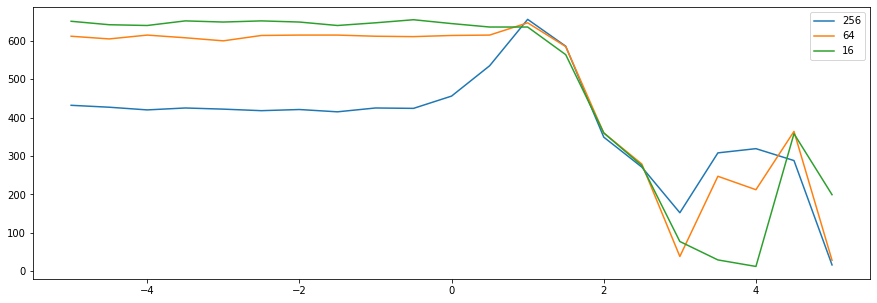

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(
    np.linspace(-5, 5, num=21),
    logs_df.loc[logs_df["factors"].eq(256), "hits"],
    label="256",
)
plt.plot(
    np.linspace(-5, 5, num=21),
    logs_df.loc[logs_df["factors"].eq(64), "hits"],
    label="64",
)
plt.plot(
    np.linspace(-5, 5, num=21),
    logs_df.loc[logs_df["factors"].eq(16), "hits"],
    label="16",
)
plt.legend()

In [21]:
max(logs_df.loc[logs_df["factors"].eq(64), "hits"]) / N_USERS

0.6861081654294804